# SIB KAGGLE PROJECT

In [44]:
#Imports
from utils.func import *
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn import preprocessing 
from sgt import SGT
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from utils.kmers import KMer_prot
from sklearn.preprocessing import StandardScaler
from propy import PyPro
from sklearn.decomposition import PCA

In [45]:
#First lets see the data!
#Train dataframe
train = pd.read_csv("/Users/André Silva/SIB_G4/Data/train.csv")
#Test dataframe
test = pd.read_csv("/Users/André Silva/SIB_G4/Data/test.csv")
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Test data is divided in {test.shape[0]} lines and {test.shape[1]} col")
print(f"Labels: {[labels for labels in train.columns]}")
print("Remove data_source")
train= train.drop(columns="data_source")
test= test.drop(columns="data_source")
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Test data is divided in {test.shape[0]} lines and {test.shape[1]} col")
print("We want to predict tm values for test data")
print(train.describe())

Train data is divided in 31390 lines and 5 col
Test data is divided in 2413 lines and 4 col
Labels: ['seq_id', 'protein_sequence', 'pH', 'data_source', 'tm']
Remove data_source
Train data is divided in 31390 lines and 4 col
Test data is divided in 2413 lines and 3 col
We want to predict tm values for test data
             seq_id            pH            tm
count  31390.000000  31104.000000  31390.000000
mean   15694.500000      6.892339     49.147337
std     9061.656811      1.612225     14.010089
min        0.000000      1.990000     -1.000000
25%     7847.250000      7.000000     42.100000
50%    15694.500000      7.000000     48.000000
75%    23541.750000      7.000000     53.800000
max    31389.000000     64.900000    130.000000


In [46]:
update_train= pd.read_csv("/Users/André Silva/SIB_G4/Data/train_updates_20220929.csv",index_col="seq_id")
train= swap_ph_tm(train,update_train)

In [47]:
train

,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7


In [48]:
print(train.isnull().sum().sort_values(ascending=False))
print(test.isnull().sum().sort_values(ascending=False))
#There are some missing values in train
#Data_source values are not that important

pH                  286
seq_id                0
protein_sequence      0
tm                    0
dtype: int64
seq_id              0
protein_sequence    0
pH                  0
dtype: int64


In [49]:
missing_data= train[train["pH"].isnull()]
missing_data

,seq_id,protein_sequence,pH,tm
484,484,ARINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,NaN,84.0
6215,6215,MASHKLLVTPLKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,73.8
6216,6216,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,85.5
6217,6217,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,67.1
6218,6218,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,83.2
...,...,...,...,...
28753,28753,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,58.9
28754,28754,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,59.4
28755,28755,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,57.8
28756,28756,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,59.3


In [50]:
train= train.drop((missing_data).index).reset_index(drop=True)
train
#Podemos remover também a data_source? Não deve de trazer nada de relevante para a analise dos dados

,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...,...
28690,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
28691,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
28692,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6
28693,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7


In [51]:
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Test data is divided in {test.shape[0]} lines and {test.shape[1]} col")
print(f"Labels: {[labels for labels in train.columns]}")

Train data is divided in 28695 lines and 4 col
Test data is divided in 2413 lines and 3 col
Labels: ['seq_id', 'protein_sequence', 'pH', 'tm']


In [52]:
train.describe()

,seq_id,pH,tm
count,28695.000000,28695.000000,28695.000000
mean,15631.432166,6.872467,51.385604
std,9235.099078,0.793184,12.076609
min,0.000000,1.990000,25.100000
25%,7447.500000,7.000000,43.700000
50%,15443.000000,7.000000,48.800000
75%,23758.500000,7.000000,54.600000
max,31389.000000,11.000000,130.000000


Next we will perform an unsupervised analysis of our data
For that we will need to obtain descriptors for our protein sequences 

In [53]:
train_array= np.array(train.loc[:,["protein_sequence"]])
len(train_array)

28695

In [54]:
# kmer = KMer_prot()
# new_data = kmer.fit_transform(train_array)

In [55]:
# new_data= StandardScaler().fit_transform(new_data)
# new_data_mean= [np.mean(line) for line in new_data]
# print("There is a maximum of :",max(new_data_mean))
# print("There is a Minimum of :",min(new_data_mean))

In [56]:
# train["protein_descriptor"] = new_data_mean

In [57]:
di_peptide= CalculateDipeptideComposition(train_array)

In [58]:
di_dataframe= pd.DataFrame(di_peptide)

In [59]:
di_dataframe

,AA,AR,AN,AD,AC,AE,AQ,AG,AH,AI,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
0,2.35,0.88,0.29,0.29,0.00,0.59,0.59,1.18,0.00,0.59,...,0.88,0.29,0.00,0.29,0.59,0.29,1.18,0.00,0.29,1.76
1,0.70,0.70,0.35,0.35,0.00,1.40,2.46,0.70,0.00,0.35,...,0.35,0.00,0.00,0.00,0.00,0.70,0.00,0.00,0.00,0.70
2,1.21,0.20,0.40,0.60,0.00,0.60,0.60,1.61,0.20,0.20,...,0.40,0.20,0.40,0.00,0.60,0.40,0.40,0.00,0.20,0.20
3,0.38,0.38,0.00,0.76,0.38,0.76,0.38,0.76,0.00,0.38,...,0.38,0.38,0.00,0.00,0.38,0.38,0.76,0.00,0.00,0.38
4,0.28,0.14,0.34,0.28,0.07,0.34,0.34,0.41,0.34,0.34,...,0.34,0.48,0.21,0.28,0.62,0.55,0.83,0.00,0.14,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28690,0.73,0.73,0.00,0.55,0.00,0.36,0.36,0.73,0.00,0.00,...,0.55,0.18,0.18,0.55,0.55,0.36,0.00,0.55,0.18,0.91
28691,1.07,0.21,0.85,0.64,0.00,0.43,0.21,0.85,0.43,0.64,...,0.64,0.43,0.21,0.21,0.21,0.43,0.00,0.00,0.21,0.85
28692,0.79,0.00,1.57,0.00,0.00,1.57,0.79,0.79,1.57,0.79,...,0.79,0.79,0.00,0.00,0.79,0.00,0.79,0.00,0.00,0.79
28693,1.01,0.68,0.00,0.34,0.00,0.51,0.17,0.68,0.17,0.84,...,1.01,0.34,0.34,0.51,0.17,0.84,0.34,0.00,0.17,1.01


In [60]:
molecular_weight = Calculate_molecular_weight(train_array)
isoelectric_point = Calculate_isoelectric_point(train_array)
aromaticity = Calculate_aromaticity(train_array)
instability_index = Calculate_instability_index(train_array)

In [61]:
train["molecular_weight"]=molecular_weight
train["isoelectric_point"]=isoelectric_point
train["aromaticity"]=aromaticity
train["instability_index"]=instability_index

In [62]:
train["pH"]

0        7.0
1        7.0
2        7.0
3        7.0
4        7.0
        ... 
28690    7.0
28691    7.0
28692    7.0
28693    7.0
28694    7.0
Name: pH, Length: 28695, dtype: float64

In [63]:
train_dataset = train.join(di_dataframe)
train_dataset= train_dataset.drop(columns=["tm"])#.drop(columns=["protein_sequence"]).drop(columns=["seq_id"])
train_dataset.sample()

,seq_id,protein_sequence,pH,molecular_weight,isoelectric_point,aromaticity,instability_index,AA,AR,AN,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
26448,29128,MVSLEQLREHETVRTDPVPESQALVDVRQLSLWYGTKQALYDISVR...,7.0,30430.92,7.772414,0.066667,41.898519,0.74,0.74,0.0,...,0.74,1.12,0.0,0.37,0.74,0.74,0.74,0.0,0.0,0.74


In [64]:
train_y= train["tm"]
train_y

0        75.7
1        50.5
2        40.5
3        47.2
4        49.5
         ... 
28690    51.8
28691    37.2
28692    64.6
28693    50.7
28694    37.6
Name: tm, Length: 28695, dtype: float64

# Embeddings

An embedding is a relativly low dimensional space into which can be translated into a high-dimensional 
vectors. This type of preprocessing make it easier to do machine learning on large inputs like sparse vectors representing protein sequences.


In [23]:
#Get protein sequence with seq_id 
corpus= train_dataset.copy()
corpus['protein_sequence'] = corpus['protein_sequence'].map(list)
#corpus.set_index('id', inplace=True)
corpus = corpus [['seq_id', 'protein_sequence']]
# change index column name because otherwise SGT does not work
corpus.columns = ['id', 'sequence']
corpus.sample(1)

,id,sequence
25742,28343,"[M, V, D, E, M, V, L, I, T, Q, Q, W, L, N, D, ..."


# SGT embedding 

https://github.com/cran2367/sgt.git

this type of embedding embeds long patterns, thin this case long protein patterns, into a finite dimension vector. The main advantage of SGT is that the long and short term patterns embedded in SGT can be tuned without any increase in the computation.


kappa -->         Tuning parameter, kappa > 0, to change the extraction of 
                    long-term dependency. Higher the value the lesser
                    the long-term dependency captured in the embedding.
                    Typical values for kappa are 1, 5, 10.
                    
lengthsensitive -->  Default false. This is set to true if the embedding of
                    should have the information of the length of the sequence.
                    If set to false then the embedding of two sequences with
                    similar pattern but different lengths will be the same.
                    lengthsensitive = false is similar to length-normalization.

In [24]:
sgt = SGT(kappa=1, 
           lengthsensitive=False, 
           mode='multiprocessing')
embeddings = sgt.fit_transform(corpus)
embeddings.sample()

embeddings['id'] = embeddings['id'].astype('int32')
embeddings.sample()

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,id,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
6908,7182,0.00289,0.000055,0.003564,0.002527,0.002735,0.001499,0.004063,0.000677,0.002145,...,0.004643,0.001572,0.000125,0.00145,0.004768,0.00163,0.00143,0.000142,0.012303,0.000277


In [30]:
embeddings.to_csv("embeddings",sep=",")

In [65]:
train_dataset_embedding = train_dataset.join(embeddings).drop(columns=["protein_sequence"])

In [70]:
train_dataset=train_dataset.drop(columns=["seq_id","protein_sequence"])
train_dataset

,pH,molecular_weight,isoelectric_point,aromaticity,instability_index,AA,AR,AN,AD,AC,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
0,7.0,36320.7244,6.109589,0.058651,28.389736,2.35,0.88,0.29,0.29,0.00,...,0.88,0.29,0.00,0.29,0.59,0.29,1.18,0.00,0.29,1.76
1,7.0,32837.9931,5.144349,0.041958,65.108392,0.70,0.70,0.35,0.35,0.00,...,0.35,0.00,0.00,0.00,0.00,0.70,0.00,0.00,0.00,0.70
2,7.0,53428.8034,9.032101,0.080483,35.089336,1.21,0.20,0.40,0.60,0.00,...,0.40,0.20,0.40,0.00,0.60,0.40,0.40,0.00,0.20,0.20
3,7.0,29475.5996,4.683840,0.071698,50.502264,0.38,0.38,0.00,0.76,0.38,...,0.38,0.38,0.00,0.00,0.38,0.38,0.76,0.00,0.00,0.38
4,7.0,158761.9814,5.917928,0.065472,45.668808,0.28,0.14,0.34,0.28,0.07,...,0.34,0.48,0.21,0.28,0.62,0.55,0.83,0.00,0.14,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28690,7.0,61997.6230,8.466327,0.089253,48.604026,0.73,0.73,0.00,0.55,0.00,...,0.55,0.18,0.18,0.55,0.55,0.36,0.00,0.55,0.18,0.91
28691,7.0,52637.6897,6.532244,0.087420,35.285096,1.07,0.21,0.85,0.64,0.00,...,0.64,0.43,0.21,0.21,0.21,0.43,0.00,0.00,0.21,0.85
28692,7.0,14203.9225,5.271214,0.117188,44.198437,0.79,0.00,1.57,0.00,0.00,...,0.79,0.79,0.00,0.00,0.79,0.00,0.79,0.00,0.00,0.79
28693,7.0,64367.8724,5.688128,0.074199,36.618398,1.01,0.68,0.00,0.34,0.00,...,1.01,0.34,0.34,0.51,0.17,0.84,0.34,0.00,0.17,1.01


In [67]:
train_dataset.shape

(28695, 406)

In [80]:

pre_processed_data = preprocessing.scale(train_dataset)

print("Media global: ", pre_processed_data.mean())
print("Desvio padrao global: ", pre_processed_data.std())
print("\nVerificar se a média e o desvio padrão estão próximos dos valores 0 e 1, respetivamente.")
print("\tMédia:", ((pre_processed_data.mean(axis=0) < 0.000001) & (pre_processed_data.mean(axis=0) > -0.000001)).all())
print("\tDesvio Padrão:", ((pre_processed_data.std(axis=0) < 1.000001) & (pre_processed_data.std(axis=0) > 0.999999)).all())

Media global:  -4.803197298218468e-18
Desvio padrao global:  1.0000000000000002

Verificar se a média e o desvio padrão estão próximos dos valores 0 e 1, respetivamente.
	Média: True
	Desvio Padrão: True


In [81]:
num_test = int(pre_processed_data.shape[0] * 0.5)

print("Numero de exemplos para teste: ", num_test)

indices = np.random.permutation(len(train_dataset))

# Get the Input data pre-processed according with the indexes
train_input = pre_processed_data[indices[1:-num_test]]
test_input = pre_processed_data[indices[-num_test:]]

# Get the output data according with the indexes
train_output = train_y[indices[1:-num_test]]
test_output = train_y[indices[-num_test:]]

Numero de exemplos para teste:  14347


In [82]:
pre_processed_data_embeddings = preprocessing.scale(train_dataset_embedding)

print("Media global: ", pre_processed_data.mean())
print("Desvio padrao global: ", pre_processed_data.std())
print("\nVerificar se a média e o desvio padrão estão próximos dos valores 0 e 1, respetivamente.")
print("\tMédia:", ((pre_processed_data.mean(axis=0) < 0.000001) & (pre_processed_data.mean(axis=0) > -0.000001)).all())
print("\tDesvio Padrão:", ((pre_processed_data.std(axis=0) < 1.000001) & (pre_processed_data.std(axis=0) > 0.999999)).all())

Media global:  -4.803197298218468e-18
Desvio padrao global:  1.0000000000000002

Verificar se a média e o desvio padrão estão próximos dos valores 0 e 1, respetivamente.
	Média: True
	Desvio Padrão: True


In [84]:
num_test = int(pre_processed_data_embeddings.shape[0] * 0.5)

print("Numero de exemplos para teste: ", num_test)

indices = np.random.permutation(len(train_dataset))

# Get the Input data pre-processed according with the indexes
train_input_embedding = pre_processed_data_embeddings[indices[1:-num_test]]
test_input_embedding= pre_processed_data_embeddings[indices[-num_test:]]

# Get the output data according with the indexes
train_output_embedding = train_y[indices[1:-num_test]]
test_output_embedding = train_y[indices[-num_test:]]

Numero de exemplos para teste:  14347


# Unsupervised machine learning

# PCA

Principal component analysis (PCA) serves as a dimentionality reduction method, often used to reduce dimensions of a large data sets, by transforming a large set of variables into a smaller one, reducing accuracy, but still contains most of the needed information.

1. Standardize the range of continuous initial variables (Previously done)
2. Compute the covariance matrix to identify correlations
3. Compute the eigenvectors and eigenvalues of the covariance matrix to identify the principal components
5. Recast the data along the principal components axes


[0.03731822 0.02475947 0.0215655  0.01765692 0.0161735  0.0140519
 0.0132888  0.01271813 0.01191654 0.01099487 0.01037038 0.01003735
 0.00954515 0.00914478 0.00862083]
0.22816232540556003
92.42991618207134


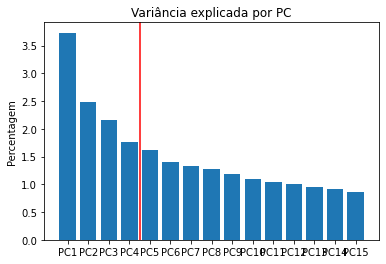

[0.04767375 0.02601007 0.01566086 0.01400817 0.01339574 0.01230877
 0.01070977 0.01044995 0.00959048 0.00925531 0.00909998 0.00871172
 0.00847683 0.00805985 0.00765983]
0.2110710863564235
169.60766898622285


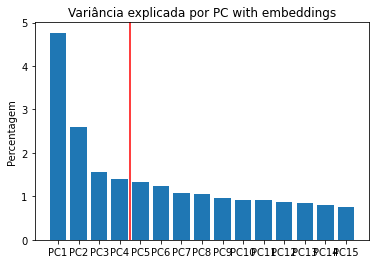

In [88]:
#Select the number of components 
n=15

pca_train= PCA(n_components=n)
pca_train.fit_transform(train_input)

print(pca_train.explained_variance_ratio_)
print(np.sum(pca_train.explained_variance_ratio_))
print(np.sum(pca_train.explained_variance_))

plt.bar(range(n), pca_train.explained_variance_ratio_*100)
plt.xticks(range(n), ['PC'+str(i) for i in range(1,n+1)])
plt.title("Variância explicada por PC")
plt.ylabel("Percentagem")
plt.axvline(3.5, color='r') # vertical
plt.show()

pca_train= PCA(n_components=n)
pca_train.fit_transform(train_input_embedding)

print(pca_train.explained_variance_ratio_)
print(np.sum(pca_train.explained_variance_ratio_))
print(np.sum(pca_train.explained_variance_))

plt.bar(range(n), pca_train.explained_variance_ratio_*100)
plt.xticks(range(n), ['PC'+str(i) for i in range(1,n+1)])
plt.title("Variância explicada por PC with embeddings")
plt.ylabel("Percentagem")
plt.axvline(3.5, color='r') # vertical
plt.show()


0.22816612995337918
92.43145742703985


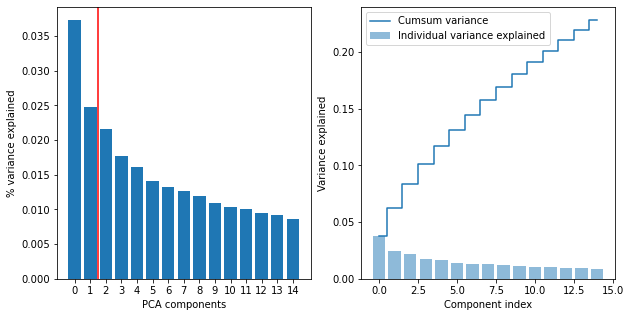

In [91]:
n=15
pca = PCA(n_components=n)
X= pca.fit_transform(train_input)
print(np.sum(pca.explained_variance_ratio_))
print(np.sum(pca.explained_variance_))
df_pca = pd.DataFrame(data=X)

features = range(pca.n_components_)
exp_var_pca = pca.explained_variance_ratio_
cumsum = np.cumsum(exp_var_pca)   
explained_variance = pca.explained_variance_

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(features, pca.explained_variance_ratio_)
ax[0].set_xlabel('PCA components')
ax[0].set_ylabel('% variance explained')
ax[0].set_xticks(features)
ax[0].axvline(x=1.5, c='r')

ax[1].bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual variance explained')
ax[1].step(range(0,len(cumsum)), cumsum, where='mid',label='Cumsum variance')
ax[1].set_ylabel('Variance explained')
ax[1].set_xlabel('Component index')
ax[1].legend(loc='best')

In [ ]:
n=15
pca = PCA(n_components=n)

X = pca.fit_transform(train_input)
print(np.sum(pca.explained_variance_ratio_))
print(np.sum(pca.explained_variance_))
df_pca = pd.DataFrame(data=X)

features = range(pca.n_components_)
exp_var_pca = pca.explained_variance_ratio_
cumsum = np.cumsum(exp_var_pca)   
explained_variance = pca.explained_variance_

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(features, pca.explained_variance_ratio_)
ax[0].set_xlabel('PCA components')
ax[0].set_ylabel('% variance explained')
ax[0].set_xticks(features)
ax[0].axvline(x=1.5, c='r')

ax[1].bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual variance explained')
ax[1].step(range(0,len(cumsum)), cumsum, where='mid',label='Cumsum variance')
ax[1].set_ylabel('Variance explained')
ax[1].set_xlabel('Component index')
ax[1].legend(loc='best')

### K-Means

K-Means is a unsupervised machine learning algorithm used to group data into clusters based on similarities.
The goal of K-means is to partition a dataset into a specified number of clusters (k) in a way that minimizes the within-cluster sum of squares. Here we present the following steps to run this algotithm:

1. Randomly selecting k initial centroids (points in the dataset that represent the center of the clusters)
2. Data point assigned to the cluster corresponding to the nearest centroid
3. The centroids are then updated to be the mean of the points in their respective clusters

This process is repeated until the centroids no longer change, or a maximum number of iterations is reached (In this case we set a maximum number of iterations)

In [92]:
ph_array=train_input[:, 0]
train_input= train_input[:, 1:]
test_input= test_input[:, 1:]

In [93]:
len(train_input[0])


404

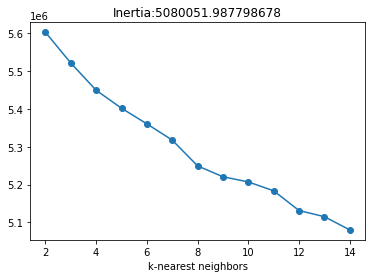

In [94]:
k=list(range(2,15))
ssd=[]
for i in k:
    kmeans=KMeans(n_clusters=i).fit(train_input)
    ssd.append(kmeans.inertia_)
    
plt.plot(k, ssd, 'o-')
plt.xlabel('k-nearest neighbors')
#plt.ylabel('Sum of squared error')
ii=kmeans.inertia_
plt.title('Inertia:{}'.format(ii))
plt.show()

In [98]:
kmeans_train= KMeans(n_clusters=15,max_iter=1000).fit(train_input)
kmeans_result=kmeans_train.predict(test_input)
inertia=kmeans_train.inertia_

In [99]:
centroids= kmeans_train.cluster_centers_
labels= kmeans_train.labels_

In [100]:
print(len(ph_array))
print(len(train_input))

14347
14347


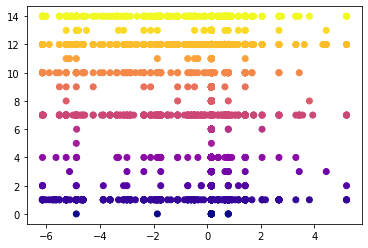

In [101]:
plt.scatter(ph_array, kmeans_result, c=kmeans_result, cmap='plasma')


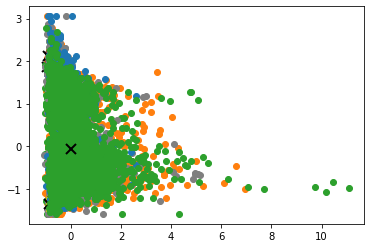

In [103]:
for i in range(len(k)):
    # select only data observations with cluster label == i
    ds = train_input[np.where(labels==i)]
    # plot the data observations (only 2 first colums)
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
    # make the centroid x's bigger
    plt.setp(lines,ms=10.0)    # x size 
    plt.setp(lines,mew=2.0)    #grossura da linha
plt.show()

In [104]:
kmeans_test = kmeans_train.predict(test_input)

In [105]:
pd.crosstab(labels, kmeans_test)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
row_0,,,,,,,,,,,,,,,
0,1,5,1,1,2,0,0,4,0,0,0,0,3,1,5
1,6,567,40,13,71,1,6,608,13,32,189,8,775,40,516
2,0,46,4,0,3,0,0,36,0,3,13,0,59,3,34
3,0,21,1,1,3,0,0,14,0,2,7,0,24,0,16
4,2,72,7,1,5,0,1,83,1,1,27,4,107,6,72
5,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0
6,0,5,0,0,1,0,1,5,0,0,3,0,15,1,5
7,3,620,29,22,72,0,9,622,12,33,208,8,859,36,540
8,1,14,0,1,3,0,0,16,0,0,4,0,17,0,16


# t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) is used to project high-dimensional data into a lower-dimensional space, typically 2 or 3 dimensions.The goal is to preserve the pairwise distances between the data points in the lower-dimensional space as much as possible.




1. Compute pairwise affinities between all data points in the high-dimensional space.
2. Use these affinities to construct a probability distribution over the data points in the high-dimensional space.
3. Embed the data points in the low-dimensional space by minimizing the divergence between the two probability distributions (i.e., the one in the high-dimensional space and the one in the low-dimensional space).
4. Repeat steps 1-3 for a number of iterations until the embedding has stabilized.

In [138]:
from sklearn.manifold import TSNE

In [139]:
tsne = TSNE(n_components=2, n_iter=1000,perplexity=40)
points = tsne.fit_transform(train_input)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


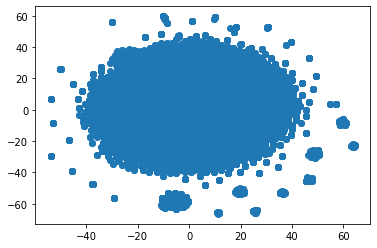

In [140]:
plt.scatter(points[:,0],points[:,1])

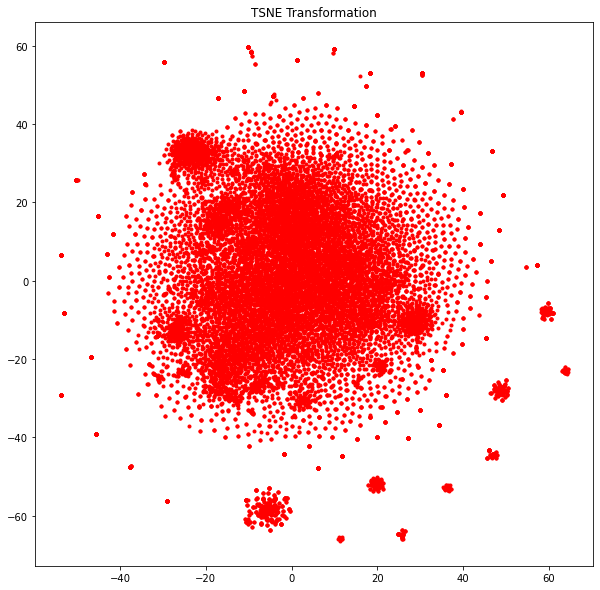

<Figure size 432x288 with 0 Axes>

In [281]:
plt.figure(figsize=(10,10))
plt.plot(points[:,0], points[:,1], 'r.')
plt.title('TSNE Transformation')
plt.show()
plt.savefig('creature.png') 